# SKIP GRAM FROM SCRATCH (Without Neg Sampling)

### Dependencies

In [37]:
import pandas as pd
import numpy as np
import re 
from collections import Counter
import nltk
import pickle
from nltk.corpus import stopwords
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


### Data Preprocessing

In [38]:
df = pd.read_csv("/Users/indusha-22955/Documents/Learning/IMDB_Dataset.csv")

def cleantext(text):
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\bbr\b', ' ', text)
    return text

df['review_lower'] = df['review'].str.lower()

def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)

df['review_no_punct'] = df['review_lower'].apply(remove_punctuation)

df['review_cleaned'] = df['review_lower'].apply(cleantext)

def tokenize_text_python(text):
    return text.split()

df['review_tokenized_python'] = df['review_cleaned'].apply(tokenize_text_python)

stop_words = set(stopwords.words('english'))
df['review_nltk'] = df['review_cleaned'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))
df.rename(columns={'review_nltk':'review_preprocessed'}, inplace=True)
corpus = " ".join(df['review_preprocessed'].values.astype(str))

def preprocess(text):
    words = text.split()
    word_counts = Counter(words)
    trimmed_words = [word for word in words if word_counts[word] > 5]
    return trimmed_words

words = preprocess(corpus)

In [39]:
words[:30]

['one',
 'reviewers',
 'mentioned',
 'watching',
 '1',
 'oz',
 'episode',
 'hooked',
 'right',
 'exactly',
 'happened',
 'first',
 'thing',
 'struck',
 'oz',
 'brutality',
 'unflinching',
 'scenes',
 'violence',
 'set',
 'right',
 'word',
 'go',
 'trust',
 'show',
 'faint',
 'hearted',
 'timid',
 'show',
 'pulls']

In [ ]:
word_counts = Counter(words)

0


In [71]:
sorted_words = sorted(word_counts, key=word_counts.get, reverse=True)
print(sorted_words[:30])

['movie', 'film', 'one', 'like', 'good', 'time', 'even', 'would', 'story', 'really', 'see', 'well', 'much', 'bad', 'get', 'people', 'great', 'also', 'first', 'made', 'make', 'way', 'could', 'movies', 'characters', 'think', 'watch', 'character', 'films', 'two']


In [41]:
def create_lookup_tables(words):
    #Create lookup tables for vocabulary
    #here we aren't conserned about the order of the words because it is going to based only of the training set which will be constructed soon 
    word_counts = Counter(words)
    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)
    int_to_vocab = {ii: word for ii, word in enumerate(sorted_vocab)}
    vocab_to_int = {word: ii for ii, word in int_to_vocab.items()}

    return vocab_to_int, int_to_vocab

In [42]:
vocab_to_int, int_to_vocab = create_lookup_tables(words)
train_words = [vocab_to_int[word] for word in words]
print(train_words[:5]) #this is the ordered word frequesncy to be precise

[2, 1920, 926, 54, 188]


In [44]:
def get_target(words, idx, window_size=5):
    """Get a list of words in a window around an index."""

    R = np.random.randint(1, window_size + 1)
    start = max(idx - R,0)
    stop = min(idx + R,len(words))
    target_words = words[start:idx] + words[idx+1:stop+1]

    return list(target_words)


def get_batches(words, batch_size, window_size=5):
    """Creates word batches as a tuple (inputs, targets)"""

    n_batches = len(words) // batch_size

    # only grab full batches
    words = words[:n_batches*batch_size]

    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for i in range(len(batch)):
            batch_x = batch[i] #value at that index
            batch_y = get_target(batch, i, window_size)
            y.extend(batch_y)
            x.extend([batch_x] * len(batch_y))
        yield x, y  # yield makes this func as a generator it seems for future ref "Think of return as ordering a giant pizza that you have to carry all at once. yield is like having a pizza delivery service that brings you one slice at a time, only when you're ready to eat it."


In [45]:
# Hyperparameters
embedding_dim = 300  # Adjust as needed, larger is usually better
learning_rate = 0.001 #Keep this low, can adjust
epochs = 2     #  Start with a small number, increase if needed
batch_size = 128   # Adjust based on memory.
window_size = 5   # Context window for skip-gram

# Vocabulary size
n_vocab = len(set(train_words))

In [51]:
n_vocab

36300

In [ ]:
W1 = np.random.randn(n_vocab, embedding_dim) / np.sqrt(n_vocab)  # Input -> Hidden
W2 = np.random.randn(embedding_dim, n_vocab) / np.sqrt(embedding_dim)  # Hidden -> Output

[[-0.00852324 -0.00973937 -0.01351748 ...  0.00092464 -0.00098097
  -0.00315408]
 [ 0.00409092  0.005996   -0.01288126 ...  0.00077296 -0.00231241
  -0.00407186]
 [-0.00039617  0.00354518  0.00113453 ...  0.00148944  0.00116061
   0.00077521]
 ...
 [ 0.00505225 -0.00244939  0.00582068 ... -0.00776884  0.0037445
   0.0031016 ]
 [-0.00673347 -0.00150596  0.00017609 ...  0.00351298 -0.00454001
   0.00019295]
 [ 0.00280544 -0.00969562  0.00353192 ...  0.00559746 -0.00860219
  -0.00022659]] [[ 3.21397763e-03  4.72130625e-02  8.41551435e-03 ...  5.17398400e-02
   1.31292246e-02  4.44375993e-02]
 [-2.60517200e-02  3.64393574e-02  4.17373593e-02 ...  1.59970625e-02
   7.94200700e-02 -3.54243620e-02]
 [ 8.47668228e-03 -5.64801655e-02  6.06397569e-03 ... -2.00651858e-01
   3.26502592e-02  5.26602228e-02]
 ...
 [ 1.34550786e-01  1.36943832e-02  5.29070578e-02 ...  1.78764135e-02
  -2.10459164e-02  3.98404660e-02]
 [ 4.32641782e-02  9.74698078e-03 -1.06541823e-02 ... -5.36310895e-02
  -6.80444011e

In [47]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))  # Subtract max for numerical stability
    return e_x / e_x.sum(axis=0)

In [ ]:

def train(train_words, vocab_to_int, int_to_vocab, epochs, batch_size, window_size, embedding_dim, learning_rate, W1, W2):
    """
    Train the skip-gram model.

    Args:
        train_words: list of integer-encoded words in the training corpus
        vocab_to_int: dictionary mapping vocabulary to integers
        int_to_vocab: dictionary mapping integers to vocabulary
        epochs: number of training epochs
        batch_size: batch size
        window_size: window size for skip-gram model
        embedding_dim: dimension of the word embeddings
        learning_rate: learning rate
        W1: weight matrix for input to hidden layer
        W2: weight matrix for hidden to output layer

    Returns:
        W1, W2: trained weight matrices
    """
    for e in range(epochs):
        batches = get_batches(train_words, batch_size, window_size)
        iteration = 0
        for x, y in batches:  # x: input word, y: target words
            iteration += 1
            x = np.array(x)
            y = np.array(y)

            h = W1[x] 
            y_hat = softmax(np.dot(h, W2)) 

            dL_dZ = y_hat
            dL_dZ[range(len(x)), y] -= 1 

            dL_dW2 = np.dot(h.T, dL_dZ) / len(x)
            dL_dW1 = np.dot(dL_dZ, W2.T) / len(x)  


            W2 -= learning_rate * dL_dW2
            for idx, word_index in enumerate(x):
                W1[word_index] -= learning_rate * dL_dW1[idx]

            if iteration % 5000 == 0:
                print(f"Epoch: {e+1}/{epochs}, Iteration: {iteration}, Loss: {np.mean(dL_dZ**2)}") 


    return W1, W2

In [64]:
h = np.array([1,2,5,3,4,6])
print(h)
print(h.T)

[1 2 5 3 4 6]
[1 2 5 3 4 6]


In [49]:
len(train_words)

5861701

In [50]:

W1, W2 = train(train_words[:50000], vocab_to_int, int_to_vocab, epochs, batch_size, window_size, embedding_dim, learning_rate, W1, W2)

In [65]:
def save_embeddings(W1, vocab_to_int, filename="word_embeddings.pkl"):
    """Saves word embeddings and vocabulary to a file."""
    data = {'embeddings': W1, 'vocab_to_int': vocab_to_int}
    with open(filename, 'wb') as f:  # 'wb' for write binary
        pickle.dump(data, f)
    print(f"Embeddings saved to {filename}")


def load_embeddings(filename="word_embeddings.pkl"):
    """Loads word embeddings and vocabulary from a file."""
    try:
        with open(filename, 'rb') as f:  # 'rb' for read binary
            data = pickle.load(f)
        return data['embeddings'], data['vocab_to_int']
    except FileNotFoundError:
        print(f"Error: File {filename} not found.")
        return None, None

# Save the embeddings after training
save_embeddings(W1, vocab_to_int)

Embeddings saved to word_embeddings.pkl


In [66]:
def cosine_similarity(v1, v2):
    """Calculate the cosine similarity between two vectors."""
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

def predict(word, W1, vocab_to_int, int_to_vocab, top_n=10):
    """
    Find the most similar words to the input word.

    Args:
        word: input word
        W1: trained weight matrix (input to hidden layer)
        vocab_to_int: dictionary mapping vocabulary to integers
        int_to_vocab: dictionary mapping integers to vocabulary
        top_n: number of most similar words to return

    Returns:
        list: list of tuples (word, similarity score)
    """
    if word not in vocab_to_int:
        print(f"Word '{word}' not in vocabulary.")
        return []

    embedding = W1[vocab_to_int[word]]
    similarities = {}
    for i in range(len(int_to_vocab)):
        if int_to_vocab[i] != word:  # Exclude the input word itself
            similarities[int_to_vocab[i]] = cosine_similarity(embedding, W1[i])

    # Sort by similarity and return the top N words
    sorted_similarities = sorted(similarities.items(), key=lambda item: item[1], reverse=True)
    return sorted_similarities[:top_n]



In [67]:
W1_loaded, vocab_to_int_loaded = load_embeddings(filename="word_embeddings.pkl")

if W1_loaded is not None and vocab_to_int_loaded is not None:
    int_to_vocab_loaded = {i: word for word, i in vocab_to_int_loaded.items()} #Create int_to_vocab
    input_word = "good"
    similar_words = predict(input_word, W1_loaded, vocab_to_int_loaded, int_to_vocab_loaded, top_n=25)

    print(f"Words most similar to '{input_word}' (using loaded embeddings):")
    for word, similarity in similar_words:
        print(f"{word}: {similarity:.4f}")

Words most similar to 'good' (using loaded embeddings):
ethan: 0.2387
fight: 0.2271
highlight: 0.2112
tbn: 0.2061
fiery: 0.2044
disgraceful: 0.1976
dahlia: 0.1929
twosome: 0.1923
inventors: 0.1922
battle: 0.1890
kapadia: 0.1886
charred: 0.1883
clavell: 0.1879
elicot: 0.1879
cindy: 0.1870
transformations: 0.1867
supernatural: 0.1863
englishmen: 0.1856
unpatriotic: 0.1856
rs: 0.1850
yimou: 0.1841
critters: 0.1841
whalley: 0.1828
gregory: 0.1825
terminology: 0.1825


Input embeddings shape: (300, 300)


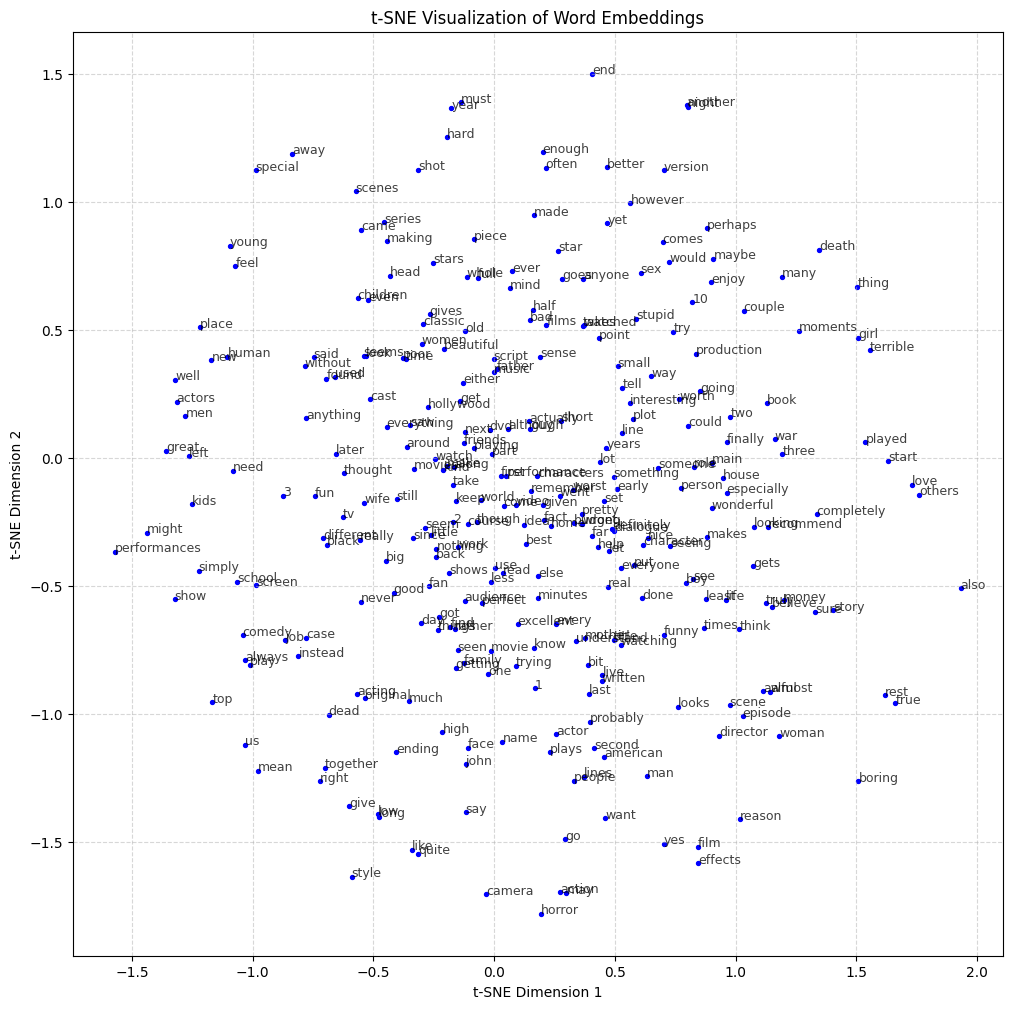

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize_embeddings(W1, int_to_vocab, viz_words=300):
    """
    Improved visualization of word embeddings using t-SNE.
    """
    
    # Reduce dimensionality using t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=100, max_iter=1000, init='pca')

    # Select the first `viz_words` embeddings
    embeddings_to_visualize = W1[:viz_words, :]

    print(f"Input embeddings shape: {embeddings_to_visualize.shape}")

    # Perform t-SNE transformation
    embed_tsne = tsne.fit_transform(embeddings_to_visualize)

    # Set up the plot
    plt.figure(figsize=(12, 12))
    
    # Normalize point sizes based on density
    x_vals, y_vals = embed_tsne[:, 0], embed_tsne[:, 1]
    
    for i in range(viz_words):
        plt.scatter(x_vals[i], y_vals[i], color='blue', s=8)  # Reduce point size for clarity
        plt.annotate(
            int_to_vocab[i], 
            (x_vals[i], y_vals[i]), 
            alpha=0.75, 
            fontsize=9  # Reduce font size slightly
        )
    
    plt.title('t-SNE Visualization of Word Embeddings')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.grid(True, linestyle='--', alpha=0.5)  # Light grid for better readability
    plt.show()

# Call function with updated parameters
visualize_embeddings(W1, int_to_vocab, viz_words=300)


In [ ]:
#Torch based
"""Have to implement"""

https://towardsdatascience.com/word2vec-with-pytorch-implementing-original-paper-2cd7040120b0/